In [1]:
!pip install fastai --upgrade

#### Recreating the 2015 idea of creating a computer system that could recognize birds considered so outrageously challenging for the software development community and it was the basis of XKCD Joke

In [3]:
!pip install 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.5 MB/s eta 0:00:00


### First Step Download the images of birds and not birds


In [4]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update
from fastcore.all import *

# We will get the maximum of 200 images
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

### Check one random image to check what type of images do we have to deal with check the url and type

In [5]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

## Get the url to download the image

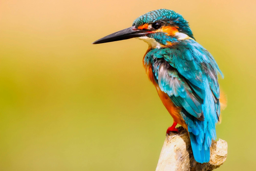

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

### Take the same approch to download the forest images

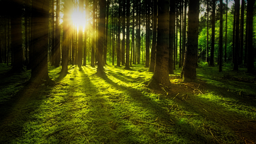

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

#### Grab a few photos of each group and save them on different folders

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

### Step 2 : Train the model
!!! Imporant if there are some photos not downloaded correctly we have to just remove them

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

### We have 9 images that have failed to be loaded
### To train the model we need an object called DataLoaders, it contains the train set images that used to create the model and validation set the images to check the accuracy of a model not used during training. We can create it using the Datablock.

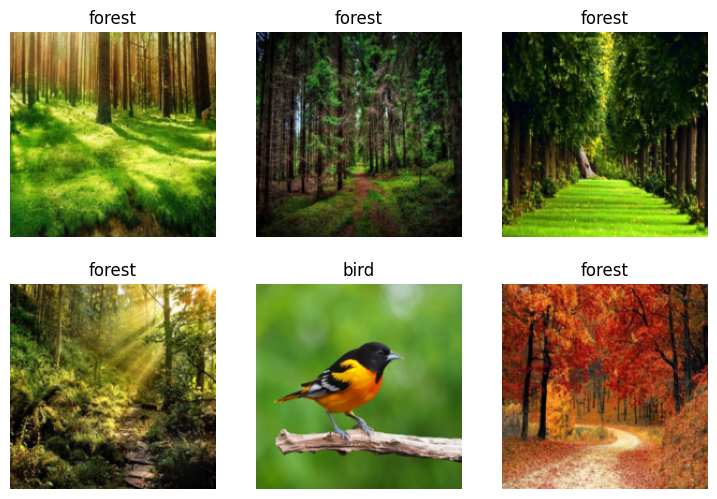

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    # Function that returns a list of all the images of the file in a path based on its extension.
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # this function simply returns the parent folder of a path because we want to know which label is the correct for our result
    get_y=parent_label,
    # we want all the images to be resized 192x192 pixels
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32) # bs = batch size

dls.show_batch(max_n=6)

### On of the fastest widely used vision algorithms is the resnet18 it can be trained in a few minutes in CPU
### Fast AI comes with a fine tuning method which automatically uses the best practises for fine tuning a pre trained model

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.621629,0.003671,0.000000,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.054323,0.002173,0.000000,01:14
1,0.028303,0.024785,0.014085,01:18
2,0.020376,0.058898,0.028169,01:07


Above in the vision_learner we have to apss of course the data, the algorithm and the metric of error.

## Use the model to build our own model on predicting the birds

In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


### Build my own project whether it is a fox or forest

Step 1: Get photos of fox and forest

In [13]:
search_images("fox photos", max_images=200)
search_images("forest photos", max_images=200)

(#200) ['https://images.pexels.com/photos/1125776/pexels-photo-1125776.jpeg?cs=srgb&dl=forest-grass-green-1125776.jpg&fm=jpg','https://wallpaperaccess.com/full/429919.jpg','https://www.wallpaperup.com/uploads/wallpapers/2015/10/01/812761/d7b9560abb6b04aeb7f201fb09c765cc.jpg','https://images.pexels.com/photos/142497/pexels-photo-142497.jpeg?cs=srgb&dl=environment-forest-grass-142497.jpg&fm=jpg','https://wallpapertag.com/wallpaper/full/8/a/8/890850-free-download-beautiful-forest-wallpaper-2406x1504.jpg','https://wallpapercave.com/wp/GD9rMAh.jpg','https://images.pexels.com/photos/41102/pexels-photo-41102.jpeg?cs=srgb&dl=nature-forest-trees-41102.jpg&fm=jpg','https://get.wallhere.com/photo/sunlight-trees-forest-nature-road-morning-mist-wilderness-jungle-rainforest-wetland-tree-autumn-woodland-3840x2400-px-habitat-natural-environment-atmospheric-phenomenon-woody-plant-geographical-feature-ecosystem-temperate-coniferous-forest-biome-old-growth-forest-temperate-broadleaf-and-mixed-forest-deci

Step 2: Name the directory to fox and forest

In [14]:
path = Path('fox_or_forest')

Step 3: Create a label function

In [15]:
def label_func(f): return 'fox' if 'fox' in f.name else 'forest'

Verify Paths in Code: check if the paths exist and contain images

In [17]:
path = Path('fox_or_forest')

if not path.exists():
    print("Path does not exist!")

for split in ['train', 'valid']:
    for category in ['fox', 'forest']:
        if not (path/split/category).exists():
            print(f"Missing folder: {split}/{category}")
        else:
            print(f"{split}/{category} has {len((path/split/category).ls())} images.")


Path does not exist!
Missing folder: train/fox
Missing folder: train/forest
Missing folder: valid/fox
Missing folder: valid/forest


if there is missing folder then create the folder structure

In [18]:
path = Path('fox_or_forest')

for split in ['train', 'valid']:
    for category in ['fox', 'forest']:
        (path/split/category).mkdir(parents=True, exist_ok=True)
        print(f"Created: {split}/{category}")

Created: train/fox
Created: train/forest
Created: valid/fox
Created: valid/forest


Re download the images

In [19]:
fox_images = search_images("fox photos", max_images=100)
forest_images = search_images("forest photos", max_images=100)

download_images(path/'train'/'fox', urls=fox_images[:80])
download_images(path/'valid'/'fox', urls=fox_images[80:])

download_images(path/'train'/'forest', urls=forest_images[:80])
download_images(path/'valid'/'forest', urls=forest_images[80:])

confirm the folder that it has the images

In [20]:
for split in ['train', 'valid']:
    for category in ['fox', 'forest']:
        print(f"{split}/{category} has {len((path/split/category).ls())} images.")

train/fox has 71 images.
train/forest has 71 images.
valid/fox has 20 images.
valid/forest has 19 images.


Identify and remove corrupt images

In [22]:
from PIL import Image

def verify_images(path):
    failed = []
    for file in path.ls():
        try:
            img = Image.open(file)
            img.verify()  # Verify integrity
        except (IOError, OSError, Image.UnidentifiedImageError):
            failed.append(file)
            file.unlink()  # Delete the corrupt file
    print(f"Deleted {len(failed)} corrupted images.")

for category in ['train/fox', 'train/forest', 'valid/fox', 'valid/forest']:
    verify_images(path/category)


Deleted 1 corrupted images.
Deleted 0 corrupted images.
Deleted 0 corrupted images.
Deleted 1 corrupted images.


Step4: Train the model

In [23]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', item_tfms=Resize(224))
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.071964,0.747349,0.270270,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.205901,0.106186,0.054054,01:37
1,0.106989,0.013245,0.000000,01:37


Predict on the test set

In [26]:
# First image from the fox folder
pred, _, probs = learn.predict('/content/fox_or_forest/valid/fox/020c3b62-9d63-45fd-8d26-63f161306411.jpg')
print(f'Prediction: {pred}, Probability: {probs.max():.4f}')

Prediction: fox, Probability: 1.0000
